Evaluation Script for trained Resnet Models

In [1]:
import torch
from dataloader import *
from CNN_Models import *
from CNN_Training import *
from model_io import *
from utils.constants import *

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def confusion_matrix_plot(cm, names, title = ""):
    # Create a figure with a larger size
    plt.figure(figsize=(6, 5))

    # Create heatmap of confusion matrix
    sns.heatmap(cm, 
                annot=True,  # Show numbers in cells
                cmap='Blues',  # Use blue color scheme
                fmt = ".2f",
                xticklabels=names,  # Use vessel type names for x-axis
                yticklabels=names)  # Use vessel type names for y-axis

    # Customize the plot
    plt.title('Confusion Matrix - ' + title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()  # Adjust layout to prevent label cutoff

    # Show the plot
    plt.show()

Obtain the data loader for the vessel activity prediction task

In [3]:
current_path = "../"
image_path = current_path + "data/images_activity"
label_path = current_path + "data/activity_label.csv"

(train, valid) = get_activity_datasets(label_path, image_path, 16) # Use batch size of 16
model = get_resnet18_classifier(ACT_N_CLASSES, pretrained=False, dropout=0.2)

In [4]:
device = torch.device("cpu")
model_path = "model/resnet-18-activity-10epoch.pth"
logs = load_from_checkpoint(model_path, model)
model = model.to(device) # Send the model to cpu for inference

Obtain the predictions given by the model (maybe slow on CPU)

In [5]:
def predict(model, dataloader):
    model.eval()
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for images, targets in tqdm(dataloader, leave=False):
            out = model(images)
            preds = list(torch.argmax(out, dim = 1))
            true_labels.extend(targets)
            pred_labels.extend(preds)
            
    return true_labels, pred_labels

train_label, train_preds = predict(model, train)
valid_label, valid_preds = predict(model,valid)
            

Validation Accuracies for Activity

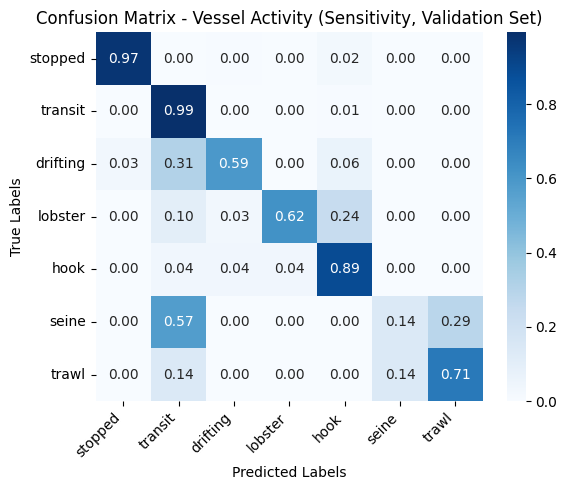

In [8]:
cm = confusion_matrix(valid_label, valid_preds)
cm_normalized = cm / cm.sum(axis=1, keepdims=True)
names = ACTIVITIES
names.remove("fishing")
confusion_matrix_plot(cm_normalized, names, "Vessel Activity (Sensitivity, Validation Set)")

In [10]:
print(classification_report(valid_label, valid_preds, target_names=names, digits=3))
print(classification_report(train_label, train_preds, target_names=names, digits=3))

              precision    recall  f1-score   support

     stopped      0.996     0.972     0.984       249
     transit      0.890     0.994     0.939       155
    drifting      0.864     0.594     0.704        32
     lobster      0.947     0.621     0.750        29
        hook      0.600     0.889     0.716        27
       seine      0.500     0.143     0.222         7
       trawl      0.714     0.714     0.714         7

    accuracy                          0.915       506
   macro avg      0.787     0.704     0.718       506
weighted avg      0.920     0.915     0.910       506

              precision    recall  f1-score   support

     stopped      0.999     1.000     0.999       894
     transit      0.971     1.000     0.985       712
    drifting      1.000     0.868     0.929       159
     lobster      1.000     0.844     0.915       109
        hook      0.780     1.000     0.876        99
       seine      1.000     0.560     0.718        25
       trawl      0.960 

Do the same thing for the type prediction model

In [12]:
current_path = "../"
image_path = current_path + "data/images_type"
label_path = current_path + "data/type_label.csv"

(train_type, valid_type) = get_type_datasets(label_path, image_path, 16) # Use batch size of 16
model_type = get_resnet18_classifier(ACT_N_CLASSES, pretrained=False, dropout=0.2)

In [13]:
device = torch.device("cpu")
model_path = "model/resnet-18-type-10epoch.pth"
logs = load_from_checkpoint(model_path, model_type)
model_type = model_type.to(device) # Send the model to cpu for inference
train_label_type, train_preds_type = predict(model_type, train_type)
valid_label_type, valid_preds_type = predict(model_type, valid_type)

Validation Accuracy for Type

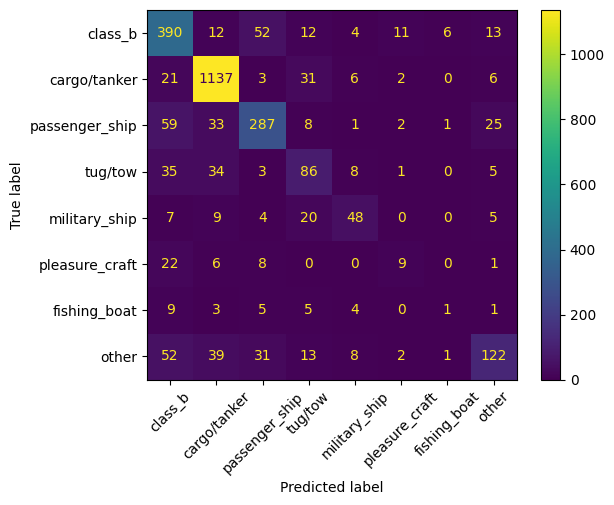

In [10]:
cm = confusion_matrix(valid_label_type, valid_preds_type)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=TYPES)
disp.plot(xticks_rotation=45)

In [15]:
print(classification_report(valid_label_type, valid_preds_type, target_names=TYPES, digits=3))
print(classification_report(train_label_type, train_preds_type, target_names=TYPES, digits=3))

                precision    recall  f1-score   support

       class_b      0.655     0.780     0.712       500
  cargo/tanker      0.893     0.943     0.917      1206
passenger_ship      0.730     0.690     0.710       416
       tug/tow      0.491     0.500     0.496       172
 military_ship      0.608     0.516     0.558        93
pleasure_craft      0.333     0.196     0.247        46
  fishing_boat      0.111     0.036     0.054        28
         other      0.685     0.455     0.547       268

      accuracy                          0.762      2729
     macro avg      0.563     0.514     0.530      2729
  weighted avg      0.752     0.762     0.753      2729

                precision    recall  f1-score   support

       class_b      0.729     0.892     0.802      1871
  cargo/tanker      0.926     0.971     0.948      4897
passenger_ship      0.820     0.747     0.782      1677
       tug/tow      0.663     0.660     0.661       703
 military_ship      0.717     0.663     0.68

### Loss Visualization

In [21]:
device = torch.device("cpu")
model_path = "model/resnet-18-dropout-overfit.pth"
logs = load_from_checkpoint(model_path, model)
model = model.to(device) # Send the model to cpu for inference
epochs = np.arange(1, 31)

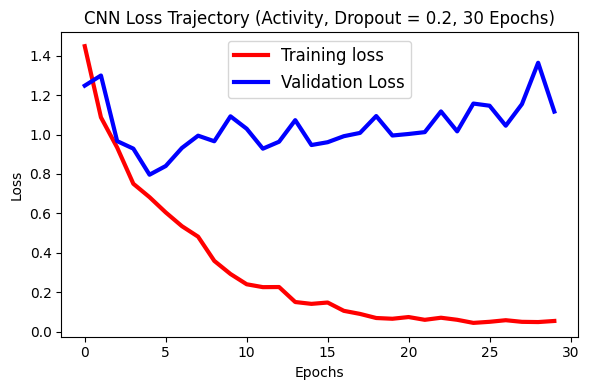

In [32]:
# Plot the confusion matrix
plt.figure(figsize=(6, 4))
plt.plot(logs["train_loss"],'r',linewidth=3.0)
plt.plot(logs['valid_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=12,loc="upper center")

plt.title('CNN Loss Trajectory (Activity, Dropout = 0.2, 30 Epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()